In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm

# Notation

This notebook solves $\frac{\mathrm{d}^2 x}{\mathrm{d}t^2} = f(x, t)$, for some $f(x, t)$.

This equation does, of course, generically have a 2D space of solutions. This notebook finds the solution that minimizes the $L^2$ norm between the solution and a set of datapoints.

# Parameters

In [2]:
# You can edit anything in this cell.
# If you do so, you should re-run the whole notebook.

h = 0.01  # Grid resolution
rng_seed_data = 1234  # Used for data generation
sigma = 0.1  # Noise level for data generation
N_samples = 10  # Number of datapoints to 'measure' from the 'true' curve

# Defines the right-hand side of the ODE. i.e. this is f(x, t).
def rhs(x, t):
    # SHO with frequency 3Hz
    omega = 2*np.pi*3.0
    omega2 = omega**2
    return -omega2*x

# Need to edit this if we change the rhs(x, t) function definition.
# You won't always know this analytically, but for simple examples we do.
def true_solution(t):
    # Pick the solution to have amplitude 1.2 and initial phase pi/4
    omega = 2*np.pi*3.0
    return 1.2 * np.sin(omega*t + np.pi/4)

# Data generation

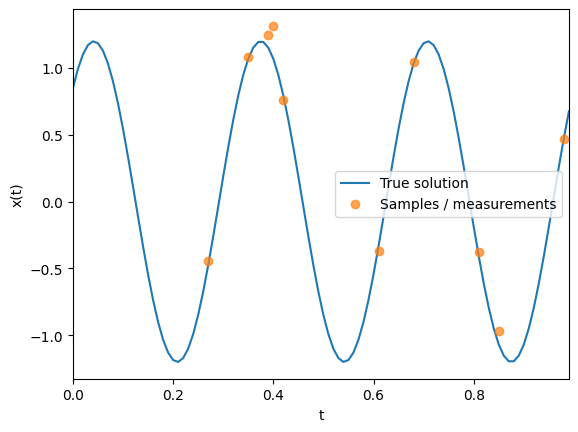

In [3]:
t_grid = np.arange(0, 1, h)  # Useful to have this for plotting.
N_grid = t_grid.shape[0]  # Number of points in this discretized grid over t.
x_true_grid = true_solution(t_grid)  # True solution curve.

rng_data = np.random.RandomState(rng_seed_data)  # Instantiate the RNG in the same cell that we will do all the calls.
idx_samples = rng_data.choice(N_grid, size=N_samples, replace=False)  # Choose which datapoints we will 'measure'
idx_samples = np.sort(idx_samples)
x_noise = rng_data.normal(scale=sigma, size=(N_samples,))  # Sample noise to be added to our datapoints.
t_samples = t_grid[idx_samples]  # Used only for plotting in this example
x_samples = x_true_grid[idx_samples] + x_noise  # Noisy datapoints
del rng_data  # Delete to prevent re-use of this RNG in the solution section.

# Plot the generated data
fig, ax = plt.subplots()
ax.plot(t_grid, x_true_grid, ls='-', marker='none', label='True solution')
ax.plot(t_samples, x_samples, ls='none', marker='o', alpha=0.7, label='Samples / measurements')
ax.set_xlim(left=t_grid[0], right=t_grid[-1])
ax.set_xlabel('t')
ax.set_ylabel('x(t)')
ax.legend()

plt.show()

# Numerical solution

## Parameters

In [4]:
# Parameters / initialization

# Parameters in this cell are specific to the method of numerical solution.
# If you change any of these, you do not need to re-run data generation.

# The lines below define a linear transformation from the natural space of the problem,
# i.e. the vector [x(t_0), x(t_1), ..., x(t_{N-1})],
# to a potentially different space [z_0, z_1, ..., z_{N-1}] in which the ODE will be solved by gradient descent.
# To solve this in the original space, set A_x2z to be the identity matrix.
A_x2z = np.zeros((N_grid, N_grid), dtype=np.float64)
A_x2z[0, 0] = 1.0  # z_0 = z(t_0)
for i in range(1, N_grid):
    # z_i = x(t_i) - x(t_{i-1}) for i > 0
    A_x2z[i, i] = 1.0
    A_x2z[i, i-1] = -1.0


N_iter = 5000  # Number of iterations of optimization.

# Initialize the solution grid.
# I don't believe there is any benefit to using random initialization, since this problem does not
# have the same requirement for symmetry-breaking that exists with the hidden neurons of a neural network.
z_solution_grid = torch.zeros(N_grid, dtype=torch.float64, requires_grad=True)

# Define the optimizer.
# This problem seems to benefit from using a second-order optimizer (which LBFGS is), and I believe that
# is due to the Hessian of loss_ODE (see below for defintion) having a very large condition number.
optimizer = torch.optim.LBFGS(lr=1, history_size=10, params=[z_solution_grid])


# Over the course of optimization we move from weighting the loss towards fitting the samples
# to weighting the loss towards satisfying the ODE.
# w_ODE = 0.0  <=> loss = L2 error of the samples
# w_ODE = 1.0  <=> loss = L2 violation of the (discretized) ODE
def get_w_ODE(iteration, N_iter):
    if iteration < 0.1*N_iter:
        # First 10% of steps: optimize mainly for fitting the samples
        w_ODE = 0.01
    elif iteration >= 0.9*N_iter:
        # Final 90% of steps: optimize mainly for satisfying the ODE
        w_ODE = 0.8
    else:
        # Linear ramp-up of w_ODE in between these iterations
        w_ODE = 0.01 + 0.79*(iteration - 0.1*N_iter)/(0.8*N_iter)
    return w_ODE

# Logging frequency. Note that you may want to log scalars more frequently than the whole solution grid.
logging_freq_scalars = 1
logging_freq_grids = 10

## Optimization

In [5]:
# Non-changeable initialization. You should not change anything in this cell.

# Invert the transformation matrix
assert np.linalg.det(A_x2z) > 1e-4  # Throw on small determinant to guard against numerical non-invertibility.
A_z2x = np.linalg.inv(A_x2z)
A_z2x_torch = torch.tensor(A_z2x)  # We'll need this is in the loss

# Put the 'samples' / 'measurements' in torch
x_samples_torch = torch.tensor(x_samples)
# ...and the indices they were sampled at.
idx_samples_torch = torch.tensor(idx_samples)
# Need this for the case that we have a non-autonomous system.
t_grid_torch = torch.tensor(t_grid)

In [6]:
# Loss function defintions

# The loss for the optimization problem has two parts:
# loss_data measures the l2 error of the data relative to our current solution x(t_0), x(t_1), ..., x(t_{N-1})
# loss_ODE measures the l2 norm of the local violation of the ODE.
# Our aim is to bring loss_ODE to zero while keeping loss_data as small as possible.

# You should not change anything in this cell.

# Note that loss_data is normalized by the number of samples.
def loss_data(z):
    x = A_z2x_torch @ z
    x_at_sample_points = x[idx_samples_torch]
    error_of_samples = (x_at_sample_points - x_samples_torch)
    loss_val = 0.5*torch.sum(error_of_samples**2)
    loss_val = loss_val / N_samples
    return loss_val

# Note that this loss is a sum over only the interior points, 1, 2, ..., N-2.
# This is because we do not have sufficient data to compute the second derivative at points 0 and N-1.
# This should be consistent with your intuition: if we simply demands that loss_ODE = 0, we would have N-2 equations in N unknowns.
# This would (typically) have a two-dimensional space of solutions, which is what we should expect for a 2nd order ODE.
def loss_ODE(z):
    x = A_z2x_torch @ z
    # Note the factor of h^-2. As h is increased (i.e. the grid is made finer) this should converge to the value of the
    # second derivative (so long as x(t) is twice-differentiable).
    second_deriv = h**(-2) * (x[:-2] - 2.0*x[1:-1] + x[2:])
    rhs_torch = rhs(x[1:-1], t_grid_torch[1:-1])
    # Note the factor of h. This cancels out the implicit factor of N_grid from the sum.
    # Alternatively, think of this loss as the (approximation to) the integral of the l2-violation of the ODE.
    loss_val = 0.5*h*torch.sum((second_deriv - rhs_torch)**2)
    return loss_val

In [7]:
# Optimization

# Initialize logging history
log_scalars = []
log_grids = []

for iteration in tqdm(range(N_iter)):
    w_ODE = get_w_ODE(iteration, N_iter)

    # Pass forward through the network
    loss_data_torch = loss_data(z_solution_grid)
    loss_ODE_torch = loss_ODE(z_solution_grid)
    loss_total_torch = (1.0 - w_ODE) * loss_data_torch + w_ODE * loss_ODE_torch

    # Store these for logging
    loss_val_data = loss_data_torch.detach().item()
    loss_val_ODE = loss_ODE_torch.detach().item()
    loss_val_total = loss_total_torch.detach().item()

    # Step the optimizer, updating z_solution_grid.
    optimizer.zero_grad()
    loss_total_torch.backward()
    # Stepping the LBFGS optimizer requires a closure for evaluating the loss function
    if type(optimizer) is torch.optim.LBFGS:
        optimizer.step(lambda: (1.0 - w_ODE) * loss_data(z_solution_grid) + w_ODE * loss_ODE(z_solution_grid))
    else:
        optimizer.step()

    # In many of my early experiments, the solution became NaN due to numerical instability.
    # If this happens, it is useful to fail at this point. It is also helpful to know which iteration this happened at.
    if z_solution_grid.isnan().any().item():
        error_msg = f'NaNs appeared in solution after iteration {iteration}'
        raise ValueError(error_msg)
    
    if iteration % logging_freq_scalars == 0:
        log_scalars.append({
            'iteration': iteration,
            'w_ODE': w_ODE,
            'loss_data': loss_val_data,
            'loss_ODE': loss_val_ODE,
            'loss_total': loss_val_total,
        })

    if iteration % logging_freq_grids == 0:
        log_grids.append({
            'iteration': iteration,
            'z_grid': z_solution_grid.detach().numpy(),
            'x_grid': (A_z2x_torch @ z_solution_grid).detach().numpy(),
        })

# Convert the solution back to x-space.
# This may already be stored in the logs (if logging_freq_grids divides N_iter).
x_solution_grid = (A_z2x_torch @ z_solution_grid).detach().numpy()

100%|██████████████████████████████████████| 5000/5000 [00:05<00:00, 917.74it/s]


## Results

Text(0, 0.5, 'w_ODE')

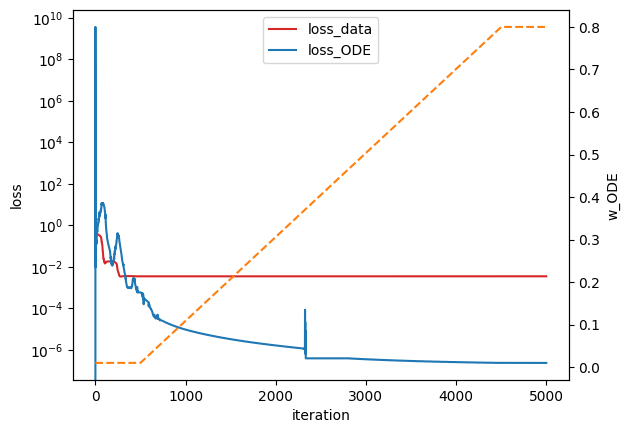

In [8]:
# Plot the progress of the optimizer.
# This is a useful diagnostic for figuring out if the solution has converged.
# Based on this, you may want to go back and re-run the optimization with different
# parameters (N_iter, get_w_ODE, a different optimizer, etc.)
# This should eventually be replaced by some heuristics so that SR can be done without manual intervention.

fig, ax = plt.subplots()

ax.plot([d['iteration'] for d in log_scalars], [d['loss_data'] for d in log_scalars],
        marker='none', ls='-', color='tab:red', label='loss_data')
ax.plot([d['iteration'] for d in log_scalars], [d['loss_ODE'] for d in log_scalars],
        marker='none', ls='-', color='tab:blue', label='loss_ODE')
ax.legend(loc='upper center')

#ax.set_ylim(bottom=0.0, top=1)
ax.set_yscale('log')
ax.set_xlabel('iteration')
ax.set_ylabel('loss')

ax2 = ax.twinx()
ax2.plot([d['iteration'] for d in log_scalars], [d['w_ODE'] for d in log_scalars],
        marker='none', ls='--', color='tab:orange', label='w_ODE')
ax2.set_ylabel('w_ODE')

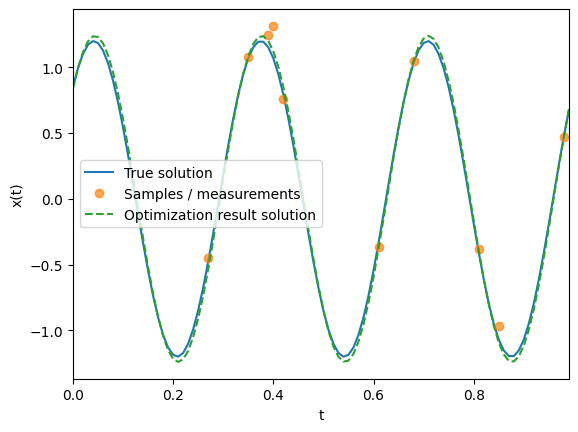

In [9]:
# Plot the results of the optimization as x(t).
# This is useful as a qualitative visual check that the optimization behaved as expected.
fig, ax = plt.subplots()
ax.plot(t_grid, x_true_grid, ls='-', marker='none', label='True solution')
ax.plot(t_samples, x_samples, ls='none', marker='o', alpha=0.7, label='Samples / measurements')
ax.plot(t_grid, x_solution_grid, ls='--', marker='none', label='Optimization result solution')
ax.set_xlim(left=t_grid[0], right=t_grid[-1])
ax.set_xlabel('t')
ax.set_ylabel('x(t)')
ax.legend()

plt.show()

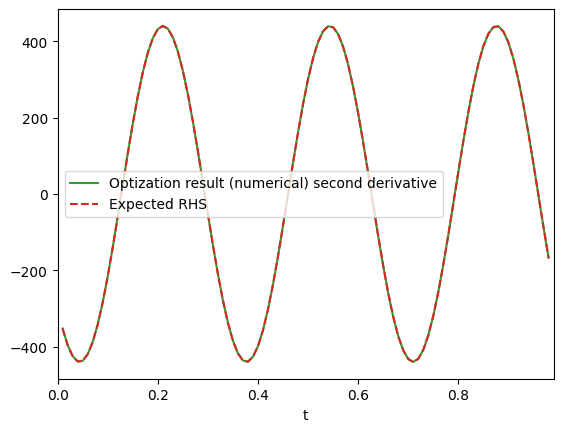

In [10]:
# Plot the second derivate against the RHS.
# This is useful as a qualitative visual check that the optimization successfully imposed the ODE.
fig, ax = plt.subplots()

second_deriv_solution_grid = h**(-2) * (x_solution_grid[:-2] - 2.0*x_solution_grid[1:-1] + x_solution_grid[2:])
ax.plot(t_grid[1:-1], second_deriv_solution_grid,
        ls='-', marker='none', color='tab:green', label='Optization result (numerical) second derivative')
ax.plot(t_grid[1:-1], rhs(x_solution_grid[1:-1], t_grid[1:-1]),
        ls='--', marker='none', color='tab:red', label='Expected RHS')
ax.set_xlim(left=t_grid[0], right=t_grid[-1])
ax.set_xlabel('t')
ax.legend()

plt.show()

In [11]:
# # Animate the optimization process.

# fig, ax = plt.subplots()
# ax.set_xlim(left=t_grid[0], right=t_grid[-1])
# ax.set_ylim(bottom=x_true_grid.min(), top=x_true_grid.max())
# line_true = ax.plot(t_grid, x_true_grid, ls='-', marker='none')
# scatter_samples = ax.plot(t_samples, x_samples, ls='none', marker='o', alpha=0.7)
# ax.set_xlabel('t')
# ax.set_ylabel('x(t)')

# # This will be updated by the animation
# line_optim = ax.plot(t_grid, log_grids[0]['x_grid'], ls='--', marker='none')[0]

# def update(frame):
#     line_optim.set_ydata(log_grids[frame]['x_grid'])

# interval = 41  # 41ms per frame ~ 24 fps
# ani = animation.FuncAnimation(fig=fig, func=update, frames=len(log_grids), interval=interval)
# ani.save('./animation.mp4', writer='ffmpeg')
# plt.show()